# Mapping of registered lightning arroud wind-turbines

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import timezone
#import datetime as dt
import json
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
#%pylab inline --no-import-all
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import time
os.environ['TZ'] = 'UTC'
time.tzset()
import matplotlib.colors as colors
import json
import matplotlib
import statistics

hdr_t = np.dtype([
    ('magic', 'u4'),
    ('id', 'u4'),
    ('timestamp', 'u4'),
    ('gps_flags', 'u1'),
    ('gps_sat', 'u1'),
    ('gps_lat', 'f4'),
    ('gps_long', 'f4'),
    ('gps_alt', 'u2'),
    ('gps_hour', 'u1'),
    ('gps_min', 'u1'),
    ('gps_sec', 'u1'),
    ('num_energy_data', 'u2'),
], align=True)

energy_data_t = np.dtype([
    ('info', 'u1'),
    ('timestamp_us', 'u4'),
    ('energy', 'f4'),
], align=True)

def read_rt_dat_file(filename):
    ret_dtype = np.dtype([
        ('time', 'u4'),
        ('time_us', 'u4'),
        ('energy', 'f4'),
        ('info', 'u1'),
        ('gps_lat', 'f4'),
        ('gps_long', 'f4'),
        ('gps_alt', 'u2')
    ])
    
    ret = np.zeros(0, dtype=ret_dtype)
    pieces = []

    with open(filename, 'r') as f:
        while True:
            try:
                hdr = np.fromfile(f, dtype=hdr_t, count=1)[0]
            except IndexError:
                break
            if hdr['magic'] != 0xaaaabbbb:
                raise Exception('corrupted data, magic mismatch')
                
            energy_data = np.fromfile(f, dtype=energy_data_t, count=hdr['num_energy_data'])
            piece = np.zeros(len(energy_data), dtype=ret_dtype)
            piece['time'] = hdr['timestamp']
            piece['time_us'] = energy_data['timestamp_us']
            piece['energy'] = energy_data['energy']
            piece['info'] = energy_data['info']
            piece['gps_lat'] = hdr['gps_lat']
            piece['gps_long'] = hdr['gps_long']
            piece['gps_alt'] = hdr['gps_alt']
            pieces.append(piece)
    return np.concatenate(pieces)

# Haversine formula for calculating the distance between two points on a sphere
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Vectorizing the Haversine formula
vec_haversine = np.vectorize(haversine)


In [90]:
#lat=51.7656581
#lon=10.6106400
#start=pd.Timestamp('2023-02-01 12:00') # Winter s dirou
#end=pd.Timestamp('2023-02-02 2:00')

lat=50.1006197
lon=10.7797819


start=pd.Timestamp('2023-11-8 2:00') # Only one stroke
end=pd.Timestamp('2023-11-8 3:00')

#start=pd.Timestamp('2023-6-5 13:00') 
#end=pd.Timestamp('2023-6-5 18:00')

# Please comment not relevant time intervals
start=pd.Timestamp('2023-01-13 12:00') # Winter
end=pd.Timestamp('2023-01-13 14:00')

#start=pd.Timestamp('2023-02-01 20:00') # Winter
#end=pd.Timestamp('2023-02-02 2:00')

#start=pd.Timestamp('2023-02-25 08:00') # Winter
#end=pd.Timestamp('2023-02-25 15:00')

#start=pd.Timestamp('2023-03-10 10:00') # Winter
#end=pd.Timestamp('2023-03-10 22:00')

#start=pd.Timestamp('2023-03-13 15:00') # Winter
#end=pd.Timestamp('2023-03-13 22:00')

#start=pd.Timestamp('2023-03-30 11:00') # Winter
#end=pd.Timestamp('2023-03-30 19:00')

start=pd.Timestamp('2023-03-30 11:00') 
end=pd.Timestamp('2023-03-30 19:00')

#start=pd.Timestamp('2023-6-8 2:00') 
#end=pd.Timestamp('2023-6-8 20:00')

#start=pd.Timestamp('2023-11-24 07:00') # Winter
#end=pd.Timestamp('2023-11-24 18:00')

#start=pd.Timestamp('2023-12-21 17:00') # Winter
#end=pd.Timestamp('2023-12-21 23:00')

#start=pd.Timestamp('2023-12-22 19:00') # Winter
#end=pd.Timestamp('2023-12-22 23:50')


sitename = str(start)
radius_error = 1.4
#radius_error = 5.6

BLITZ_DIST = 150


In [91]:
# set random azimuth angles (seed for reproducablity)
npoints = 1000
np.random.seed(1235)
rand_azimuths_deg = np.random.random(npoints)*360

import cartopy.geodesic as cgeo

# set random distances (seed for reproducablity)
np.random.seed(6341)
rand_distances = BLITZ_DIST*1000*np.sqrt((np.random.random(npoints))) # np.random.uniform(low=0, high=radius, size=npoints)

blitz = pd.DataFrame(columns=['lat', 'lon'])
blitz.lon = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,0]
blitz.lat = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,1]


In [92]:
# Load of lightning data

blitz = pd.read_csv('./data/blitz_'+sitename+'bourka.csv', sep=',', low_memory=False, on_bad_lines='skip')


In [93]:
# Reduction of distant lightnings

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz = blitz.loc[blitz['km'] <= BLITZ_DIST]
blitz.reset_index(inplace=True)

https://overpass-turbo.eu/#

// @name tower

/*
This has been generated by the overpass-turbo wizard.
The original search was:
“ man_made = tower”
*/
[out:json][timeout:25];
// gather results
nwr["man_made"="tower"](48.7022575, 7.0337444,51.5979428, 13.5376508);
// print results
out center;


// @name wind_turbine

/*
This has been generated by the overpass-turbo wizard.
The original search was:
“generator:method=wind_turbine”
*/
[out:json][timeout:25];
// gather results
nwr["generator:source"="wind"](48.7022575, 7.0337444,51.5979428, 13.5376508);
// print results
out center;

In [94]:
json_file = '/home/kakl/vanice/data/windturbine.geojson'

with open(json_file) as f:
    data = json.load(f)
windturbines = pd.json_normalize(data,'features')

windturbines['lon'] = windturbines['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
windturbines['lat'] = windturbines['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [95]:
# Reduction of wind-turbines points

windturbines['lonRad']=np.radians(windturbines.lon)
windturbines['latRad']=np.radians(windturbines.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
windturbines['DlonRad']=lonRad-windturbines.lonRad
windturbines['DlatRad']=latRad-windturbines.latRad
windturbines['a']=np.sin(windturbines.DlatRad/2.)**2. + np.cos(windturbines.latRad) * np.cos(latRad) * np.sin(windturbines.DlonRad/2.)**2.
windturbines['km'] = 2. * np.arcsin(np.sqrt(windturbines.a))*6378.
windturbines = windturbines.loc[windturbines['km'] <= BLITZ_DIST]
windturbines.reset_index(inplace=True)

In [96]:
# Identify lightning with nearby structures

# Converting coordinates to radians
blitz['latRad'] = np.radians(blitz['lat'])
blitz['lonRad'] = np.radians(blitz['lon'])
windturbines['latRad'] = np.radians(windturbines['lat'])
windturbines['lonRad'] = np.radians(windturbines['lon'])

# Converting pandas.Series to numpy.array
latRad_blitz = blitz['latRad'].to_numpy()
lonRad_blitz = blitz['lonRad'].to_numpy()
latRad_windturbines = windturbines['latRad'].to_numpy()
lonRad_windturbines = windturbines['lonRad'].to_numpy()

# Calculating distance between each point in 'blitz' and all points in 'structures'
distances_wt = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis],
                          latRad_windturbines, lonRad_windturbines)
distances_wt2 = vec_haversine(latRad_windturbines[:, np.newaxis], lonRad_windturbines[:, np.newaxis],
                          latRad_blitz, lonRad_blitz)

# Marking points in 'blitz' that are within 1.4 km of any point in 'structures'
blitz['is_close'] = False
blitz['is_close'] = np.any(distances_wt <= (radius_error), axis=1)
windturbines['is_close'] = np.any(distances_wt2 <= (radius_error), axis=1)
vetrniky = len(blitz.loc[blitz['is_close']==True])
blitz['vetrnik'] = blitz['is_close']

In [97]:
json_file = '/home/kakl/vanice/data/tower.geojson'

with open(json_file) as f:
    data = json.load(f)
towers = pd.json_normalize(data,'features')

towers['lon'] = towers['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
towers['lat'] = towers['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [98]:
# Reduction of distant tall structures

towers['lonRad']=np.radians(towers.lon)
towers['latRad']=np.radians(towers.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
towers['DlonRad']=lonRad-towers.lonRad
towers['DlatRad']=latRad-towers.latRad
towers['a']=np.sin(towers.DlatRad/2.)**2. + np.cos(towers.latRad) * np.cos(latRad) * np.sin(towers.DlonRad/2.)**2.
towers['km'] = 2. * np.arcsin(np.sqrt(towers.a))*6378.
towers = towers.loc[towers['km'] <= BLITZ_DIST]


In [99]:
# Identify lightning with nearby structures

# Converting coordinates to radians
blitz['latRad'] = np.radians(blitz['lat'])
blitz['lonRad'] = np.radians(blitz['lon'])
towers['latRad'] = np.radians(towers['lat'])
towers['lonRad'] = np.radians(towers['lon'])

# Converting pandas.Series to numpy.array
latRad_blitz = blitz['latRad'].to_numpy()
lonRad_blitz = blitz['lonRad'].to_numpy()
latRad_towers = towers['latRad'].to_numpy()
lonRad_towers = towers['lonRad'].to_numpy()

# Calculating distance between each point in 'blitz' and all points in 'structures'
distances_tw = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis],
                          latRad_towers, lonRad_towers)

# Marking points in 'blitz' that are within 1.4 km of any point in 'structures'
blitz['is_close'] = False
blitz['is_close'] = np.any(distances_tw <= (radius_error), axis=1)
veze = len(blitz.loc[blitz['is_close']==True])
blitz['both'] = blitz['vetrnik'] | blitz['is_close']

In [100]:
json_file = '/home/kakl/vanice/data/mast.geojson'

with open(json_file) as f:
    data = json.load(f)
masts = pd.json_normalize(data,'features')

masts['lon'] = masts['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
masts['lat'] = masts['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [101]:
# Reduction of distant tall structures

masts['lonRad']=np.radians(masts.lon)
masts['latRad']=np.radians(masts.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
masts['DlonRad']=lonRad-masts.lonRad
masts['DlatRad']=latRad-masts.latRad
masts['a']=np.sin(masts.DlatRad/2.)**2. + np.cos(masts.latRad) * np.cos(latRad) * np.sin(masts.DlonRad/2.)**2.
masts['km'] = 2. * np.arcsin(np.sqrt(masts.a))*6378.
masts = masts.loc[masts['km'] <= BLITZ_DIST]


In [102]:
# Identify lightning with nearby structures

# Haversine formula for calculating the distance between two points on a sphere
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Vectorizing the Haversine formula
vec_haversine = np.vectorize(haversine)

# Converting coordinates to radians
blitz['latRad'] = np.radians(blitz['lat'])
blitz['lonRad'] = np.radians(blitz['lon'])
masts['latRad'] = np.radians(masts['lat'])
masts['lonRad'] = np.radians(masts['lon'])

# Converting pandas.Series to numpy.array
latRad_blitz = blitz['latRad'].to_numpy()
lonRad_blitz = blitz['lonRad'].to_numpy()
latRad_masts = masts['latRad'].to_numpy()
lonRad_masts = masts['lonRad'].to_numpy()

# Calculating distance between each point in 'blitz' and all points in 'structures'
distances_mt = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis],
                          latRad_masts, lonRad_masts)

# Marking points in 'blitz' that are within 1.4 km of any point in 'structures'
blitz['is_close'] = False
blitz['is_close'] = np.any(distances_mt <= (radius_error), axis=1)
stozary = len(blitz.loc[blitz['is_close']==True])

In [103]:
json_file = '/home/kakl/vanice/data/chimney.geojson'

with open(json_file) as f:
    data = json.load(f)
chimneys = pd.json_normalize(data,'features')

chimneys['lon'] = chimneys['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
chimneys['lat'] = chimneys['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [104]:
# Reduction of distant tall structures

chimneys['lonRad']=np.radians(chimneys.lon)
chimneys['latRad']=np.radians(chimneys.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
chimneys['DlonRad']=lonRad-chimneys.lonRad
chimneys['DlatRad']=latRad-chimneys.latRad
chimneys['a']=np.sin(chimneys.DlatRad/2.)**2. + np.cos(chimneys.latRad) * np.cos(latRad) * np.sin(chimneys.DlonRad/2.)**2.
chimneys['km'] = 2. * np.arcsin(np.sqrt(chimneys.a))*6378.
chimneys = chimneys.loc[chimneys['km'] <= BLITZ_DIST]


In [105]:
# Identify lightning with nearby structures

# Haversine formula for calculating the distance between two points on a sphere
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Vectorizing the Haversine formula
vec_haversine = np.vectorize(haversine)

# Converting coordinates to radians
blitz['latRad'] = np.radians(blitz['lat'])
blitz['lonRad'] = np.radians(blitz['lon'])
chimneys['latRad'] = np.radians(chimneys['lat'])
chimneys['lonRad'] = np.radians(chimneys['lon'])

# Converting pandas.Series to numpy.array
latRad_blitz = blitz['latRad'].to_numpy()
lonRad_blitz = blitz['lonRad'].to_numpy()
latRad_chimneys = chimneys['latRad'].to_numpy()
lonRad_chimneys = chimneys['lonRad'].to_numpy()

# Calculating distance between each point in 'blitz' and all points in 'structures'
distances_ch = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis],
                          latRad_chimneys, lonRad_chimneys)

# Marking points in 'blitz' that are within 1.4 km of any point in 'structures'
blitz['is_close'] = False
blitz['is_close'] = np.any(distances_ch <= (radius_error), axis=1)
kominy = len(blitz.loc[blitz['is_close']==True])


In [106]:
celkem = len(blitz)
bez = len(blitz.loc[blitz['both']==False])
print(start, '-', end)
median_wt = round(statistics.median(np.amin(distances_wt, axis=1)),1)
median_tw = round(statistics.median(np.amin(distances_tw, axis=1)),1)
median_mt = round(statistics.median(np.amin(distances_mt, axis=1)),1)
median_ch = round(statistics.median(np.amin(distances_ch, axis=1)),1)
mean_wt = round(statistics.mean(np.amin(distances_wt, axis=1)),1)
mean_tw = round(statistics.mean(np.amin(distances_tw, axis=1)),1)
mean_mt = round(statistics.mean(np.amin(distances_mt, axis=1)),1)
mean_ch = round(statistics.mean(np.amin(distances_ch, axis=1)),1)

print('Nothing found\t', bez, '\t', round(bez/(celkem/100),0),"%")

print()
print('Storm date\tStrokes\t\tMedian/Mean of distance to neares tall structure')
print('\t\t\t\tWind-turbines\tTowers\t\tMasts\t\tChimneys')
print(sitename.split()[0],'\t',celkem,'\t\t', median_wt,'/', mean_wt,'\t', median_tw,'/', mean_tw,'\t', median_mt,'/', mean_mt,'\t', median_ch,'/', mean_ch)

print()
print('Storm date\tStrokes\t\tStrokes/percent of tall structures up to 1.4 km')
print('\t\t\t\tWind-turbines\tTowers\t\tMasts\t\tChimneys')
print(sitename.split()[0],'\t',celkem,'\t\t', vetrniky,'/', round(vetrniky/(celkem/100),0),'%\t', veze,'/', round(veze/(celkem/100),0),'%\t', stozary,'/',round(stozary/(celkem/100),0),'%\t', kominy,'/', round(kominy/(celkem/100),0),'%')


2023-01-13 12:00:00 - 2023-01-13 14:00:00
Nothing found	 6 	 16.0 %

Storm date	Strokes		Median/Mean of distance to neares tall structure
				Wind-turbines	Towers		Masts		Chimneys
2023-01-13 	 38 		 0.5 / 1.3 	 1.7 / 1.8 	 4.5 / 4.0 	 8.0 / 7.8

Storm date	Strokes		Strokes/percent of tall structures up to 1.4 km
				Wind-turbines	Towers		Masts		Chimneys
2023-01-13 	 38 		 31 / 82.0 %	 7 / 18.0 %	 3 / 8.0 %	 0 / 0.0 %


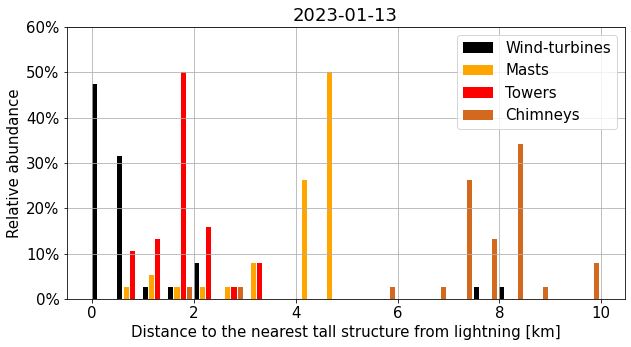

In [107]:
#plt.figure(figsize=(10,5), facecolor='lightyellow')
plt.figure(figsize=(10,5))
matplotlib.rcParams.update({'font.size': 15})
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))

BINS = 20

#plt.hist(np.amin(distances_wt,axis=1), bins=50)
#plt.hist((np.amin(distances_wt, axis=1),np.amin(distances_mt, axis=1),np.amin(distances_tw, axis=1)),color=('orange','purple','red'),edgecolor='white',label=('wind-turbines','masts','towers'),bins=np.linspace(0, 10, 40))
hh1 = np.histogram(np.amin(distances_wt, axis=1), bins= np.linspace(0, 10, BINS+1))
hh2 = np.histogram(np.amin(distances_mt, axis=1), bins= np.linspace(0, 10, BINS+1))
hh3 = np.histogram(np.amin(distances_tw, axis=1), bins= np.linspace(0, 10, BINS+1))
hh4 = np.histogram(np.amin(distances_ch, axis=1), bins= np.linspace(0, 10, BINS+1))
#plt.hist((np.amin(distances_wt, axis=1),np.amin(distances_mt, axis=1),np.amin(distances_tw, axis=1)),color=('black','orange','red'),edgecolor='white',label=('wind-turbines','masts','towers'),bins=np.linspace(0, 10, 40),density=True)
plt.ylim(0,0.6)
plt.bar(hh1[1][:-1]+0.05,hh1[0]/celkem, width=0.1, label='Wind-turbines', color='black')
plt.bar(hh2[1][:-1]+0.05+0.12,hh2[0]/celkem, width=0.1, label='Masts', color='orange')
plt.bar(hh3[1][:-1]+0.05+2*0.12,hh3[0]/celkem, width=0.1, label='Towers', color='red')
plt.bar(hh4[1][:-1]+0.05+3*0.12,hh4[0]/celkem, width=0.1, label='Chimneys', color='chocolate')
plt.legend()
plt.xlabel('Distance to the nearest tall structure from lightning [km]')
plt.ylabel('Relative abundance')
plt.title(sitename.split()[0])
plt.grid()